In [3]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [4]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
torch.backends.cudnn.enabled = True
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

True

In [12]:
%autoreload

cohort = mre_pinn.data.PatientCohort(patient_ids='0006', xarray_dir='../data/NAFLD')
#cohort = mre_pinn.data.PatientCohort.from_file('../data/NAFLD/NAFLD_2022-10-31_head10.xarrays', xarray_dir='../data/NAFLD')
cohort.create_xarrays()
cohort.save_xarrays()
#cohort.metadata
#cohort.load_xarrays()
cohort.eval_baseline()

  0%|          | 0/1 [00:00<?, ?it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55b2f9817d20)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 100

  (UseDirectionCosines "true")
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mask to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Resizing mask to (256, 256, 4)
Correcting metadata on t1_pre_in
Correcting metadata on t1_pre_water
Correcting metadata on t1_pre_out
Correcting metadata on t1_pre_fat
Correcting metadata on t2
Correcting metadata on mask
Correcting metadata on mre_raw
Correcting metadata on wave
Correcting metadata on mre
Correcting metadata on mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Convert

  return key in self.data

  return key in self.data



100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


0.8811365187168122


<IPython.core.display.Javascript object>


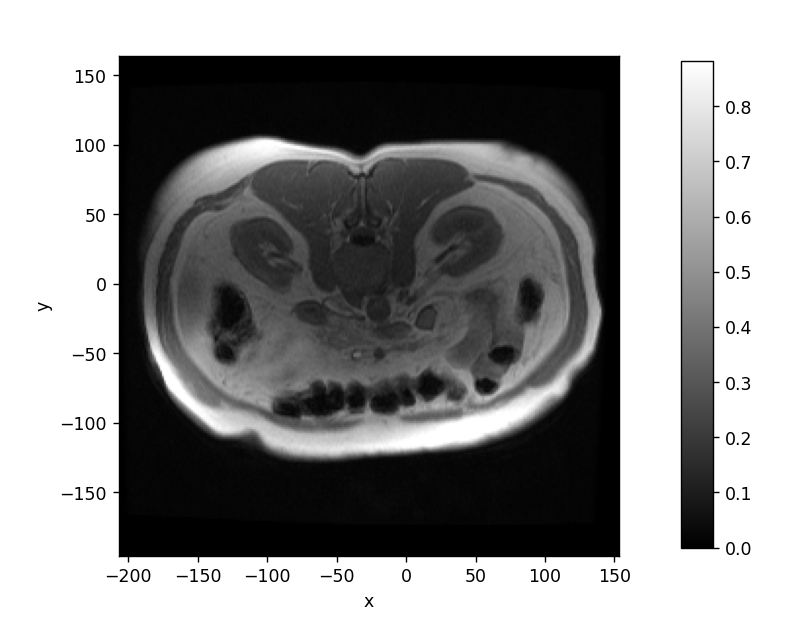

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

1.1


<IPython.core.display.Javascript object>


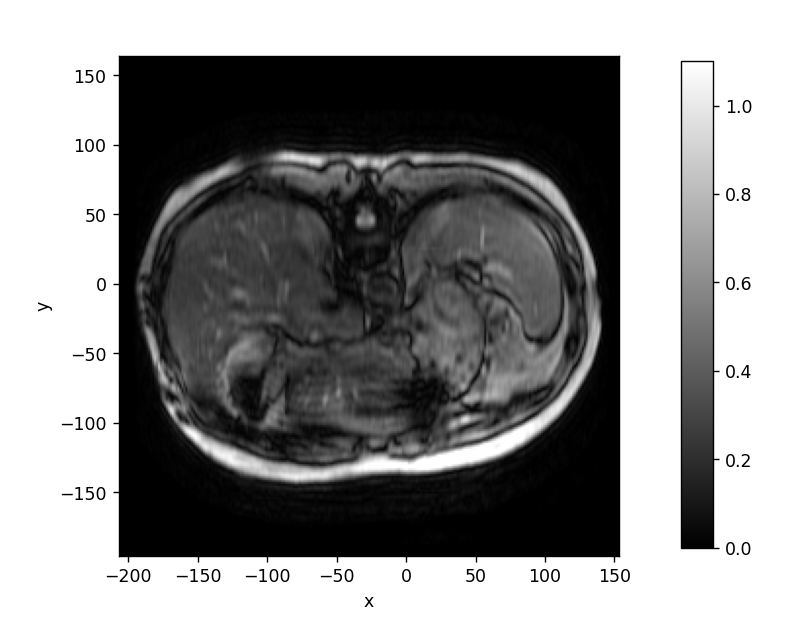

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [13]:
%autoreload
mre_sequences = ['mre_raw', 'wave', 'mre', 'mre_mask']
anat_sequences = [s for s in cohort[0].sequences if s not in mre_sequences]

cohort[0].view(anat_sequences, compare=True)
cohort[0].view(mre_sequences, compare=True)

In [15]:
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', detach=True)
pde

In [16]:
%autoreload

pino = mre_pinn.model.SpectralTransformer(
    n_spatial_dims=3,
    n_channels_in=4,
    n_channels_out=1,
    n_spatial_freqs=128,
    n_channels_model=32,
    n_conv_blocks=3,
    n_spectral_blocks=0,
    activ_fn='g',
    omega=15/300
)
pino

SpectralTransformer(
  (spectral_fwd): SpectralTransform(
    (a_linear): Linear(in_features=4, out_features=32, bias=True)
    (conv_block1): ConvBlock(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): AvgPool3d(kernel_size=2, stride=2, padding=0)
    )
    (conv_block2): ConvBlock(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): AvgPool3d(kernel_size=2, stride=2, padding=0)
    )
    (conv_block3): ConvBlock(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): AvgPool3d(kernel_size=2, stride=2, padding=0)
    )
    (x_linear): Linear(in_features=3, out_features=128, bias=True)
  )
  (spectral_inv): SpectralInverse(
    (y_linear): Linear(in_features=3, out_features=128, bias=True)
    (u_linear): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [17]:
%autoreload

model = mre_pinn.training.PINOModel(cohort, pino, pde, patch_size=None, batch_size=1)
model.compile(
    optimizer='adam',
    lr=1e-3,
    loss_weights=[1e-8, 1e0],
    loss=mre_pinn.training.losses.msae_loss
)   
test_eval = mre_pinn.testing.TestEvaluator(test_every=10, interact=True)

Compiling model...
'compile' took 0.000320 s



1645.202035522461
711.2984147338873


<IPython.core.display.Javascript object>


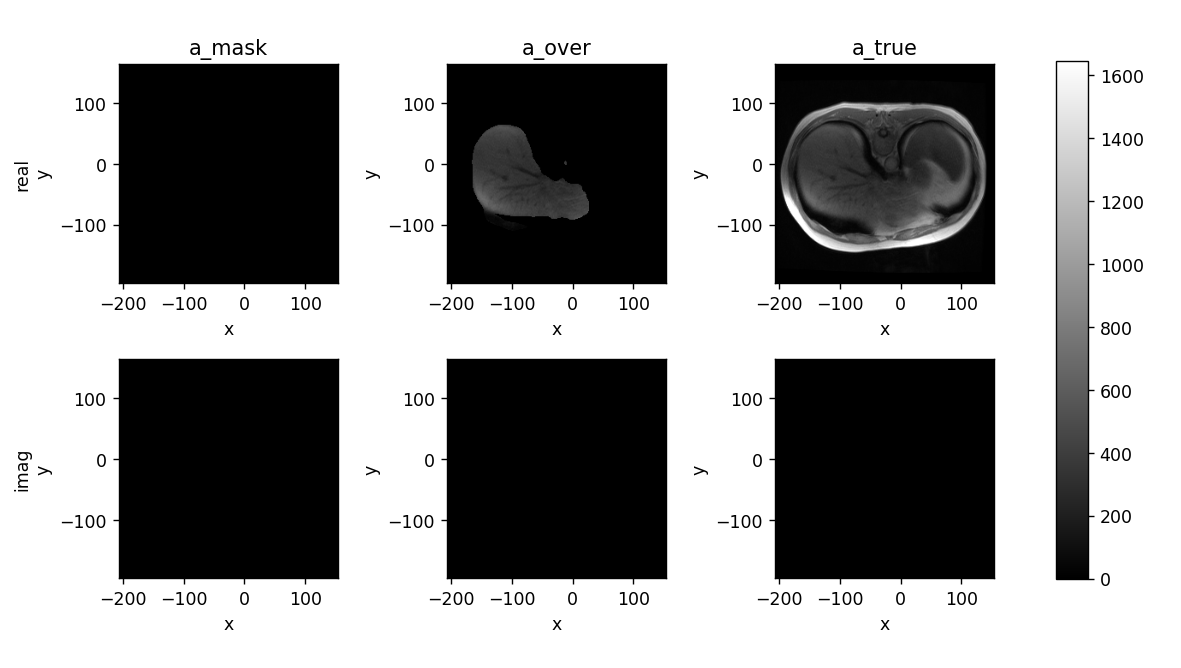

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


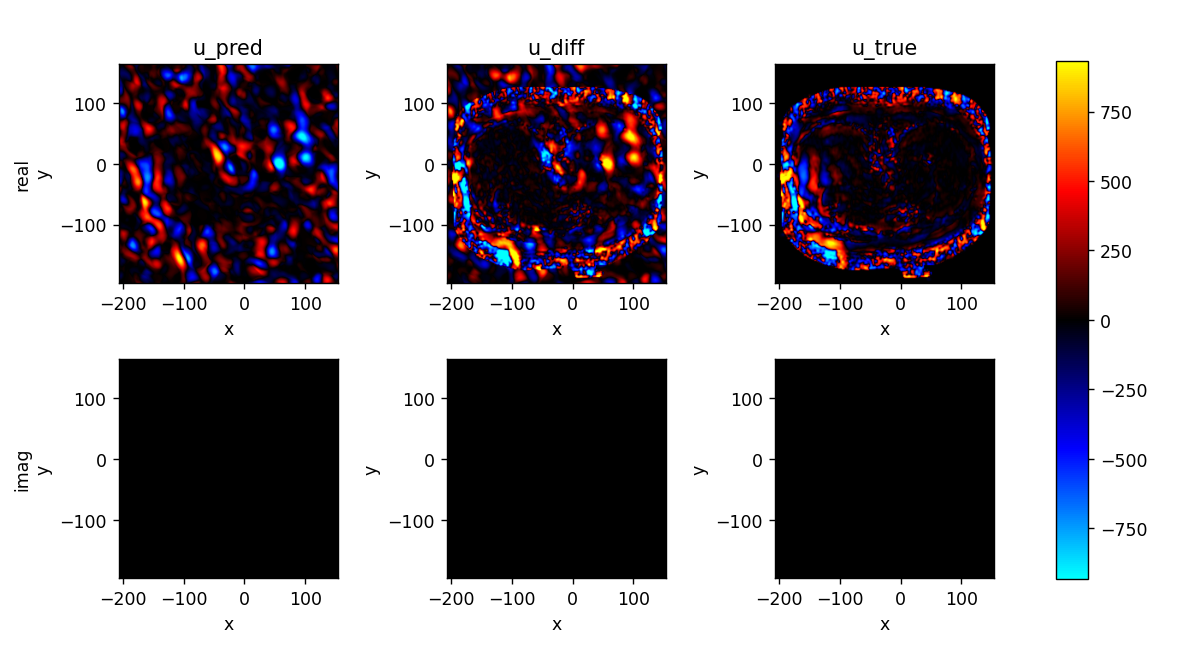

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


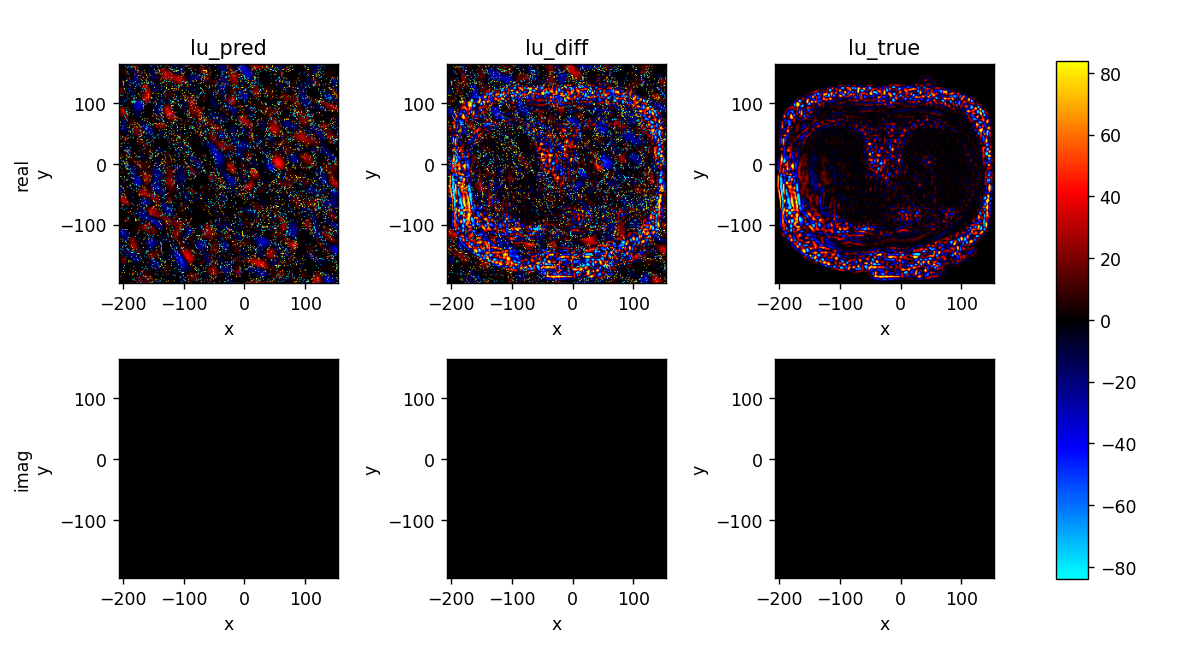

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [19]:
test_eval.model = model
test_eval.test()

In [ ]:
torch.backends.cudnn.enabled = False

model.train(10000, display_every=10, callbacks=[test_eval])

Training model...

0         [7.53e-05, 7.53e+03]    [7.53e-05, 7.53e+03]    []  
Time spent testing: 2.42%
10        [6.77e-05, 6.77e+03]    [6.77e-05, 6.77e+03]    []  
Time spent testing: 3.57%
20        [4.09e-05, 4.09e+03]    [4.09e-05, 4.09e+03]    []  
Time spent testing: 4.66%
30        [3.18e-05, 3.18e+03]    [3.18e-05, 3.18e+03]    []  
Time spent testing: 5.70%
40        [2.31e-05, 2.31e+03]    [2.31e-05, 2.31e+03]    []  
Time spent testing: 6.63%
50        [2.09e-05, 2.09e+03]    [2.09e-05, 2.09e+03]    []  
Time spent testing: 7.55%
60        [2.03e-05, 2.03e+03]    [2.03e-05, 2.03e+03]    []  
Time spent testing: 8.42%
70        [1.73e-05, 1.73e+03]    [1.73e-05, 1.73e+03]    []  
Time spent testing: 9.28%
80        [1.85e-05, 1.85e+03]    [1.85e-05, 1.85e+03]    []  
Time spent testing: 10.09%
90        [1.62e-05, 1.62e+03]    [1.62e-05, 1.62e+03]    []  
Time spent testing: 10.87%
100       [2.79e-05, 2.79e+03]    [2.79e-05, 2.79e+03]    []  
Time spent testing: 11.63%